#### Carga de librerías

In [1]:
from imutils import paths
from imutils import build_montages
from sklearn.cluster import DBSCAN
from random import seed
from random import randint
import numpy as np
import face_recognition
import argparse
import pickle
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

In [2]:
# Listado con ruta de las imagenes a procesar
# Las imáagenes se deben encontrar en la carpeta 'dataset'
imagePaths = list(paths.list_images('dataset'))

#### Se muestran algunas imágenes aleatoriamente

Number of pictures [60, 33, 94, 121, 16]


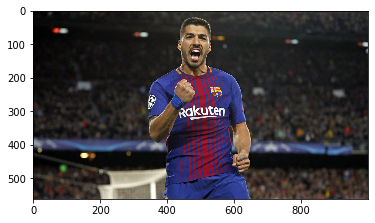

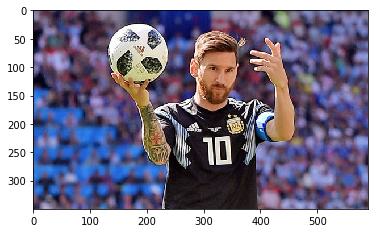

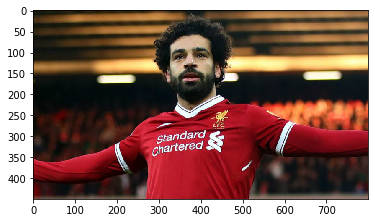

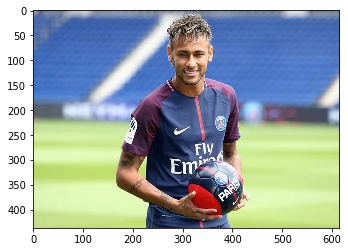

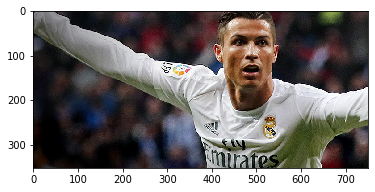

In [3]:
# listado de imagenes a mostrar
img_list = []
seed(3)

# Crea lista con imágenes aleatorias a mostrar
for _ in range(5):
    value = randint(0, len(imagePaths))
    img_list.append(value)
print('Number of pictures {}'.format(img_list))
# Muestra imágenes
for i in img_list:
    img=mpimg.imread(imagePaths[i])
    imgplot = plt.imshow(img)
    plt.show()

#### 2.1
Use la librería **face_recognition**, detecte las caras en cada imagen y genere un vector de características para cada cara. Entregue un archivo que describa el nombre de la imagen, la localización de la cara y el vector de características.

In [4]:
# lista donde se guardara el diccionario con data para cada imagen
data = []
# iteración sobre todas las rutas de imágenes
for (i, imagePath) in enumerate(imagePaths):
    # carga de imagen 
    image = cv2.imread(imagePath)
    # transformación de los colores de la imagen de BGR a RGB
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Detección de caras con el modelo por defecto 'hog'
    boxes = face_recognition.face_locations(rgb)
    # Generación de vectores con data asociada a las posiciones donde se encuentran las caras en las imágenes
    encodings = face_recognition.face_encodings(rgb, boxes)
    # Creación de diccionario con la ruta de la imagen, puntos donde se localiza la cara y el vector generado
    d = [{"imagePath": imagePath, "loc": box, "encoding": enc}
        for (box, enc) in zip(boxes, encodings)]
    # Inserción de diccionario en la lista que contiene los datos para cada imagen
    data.extend(d)

# Export de la data a archivo formato pickle
f = open('encodings', "wb")
f.write(pickle.dumps(data))
f.close()

# Export de la data a archivo .txt 
with open('face_recognition.txt', 'w') as f:
    for item in data:
        f.write("%s\n" % item)
f.close()

#### 2.2

Utilice los vectores de características para agrupar las caras de los futbolistas utilizando el algoritmo DBSCAN. Cada grupo corresponderá a un futbolista . Si usted conoce a los futbolistas pueden reemplazar los típicos IDS generados (0, 1, 2, 3 …) por sus nombres.

In [5]:
# Carga de archivo formato pickle con las rutas, lugar de la cara y encodings generados anteriormente
data_encode = pickle.loads(open('encodings', "rb").read())
# transformación de los datos a un array
data_encode = np.array(data_encode)
# Obtención de los encodings
encodings = [d["encoding"] for d in data_encode]
# Ejecución de algoritmo DBSCAN
clt = DBSCAN(eps=0.5, metric="euclidean", n_jobs=4)
# Se guardan las predicciones del algoritmo en pred
pred = clt.fit_predict(encodings)

In [6]:
print(pred)

[ 0 -1  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1
  1 -1  1  1 -1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4]


Cluster Unkwnown


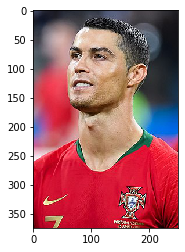

Cluster 0


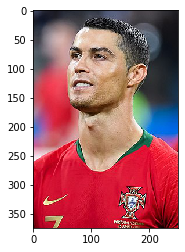

Cluster 1


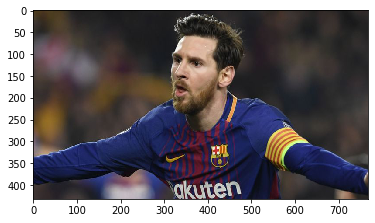

Cluster 2


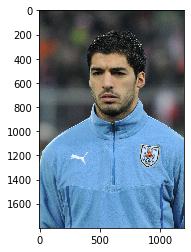

Cluster 3


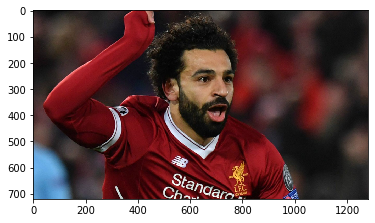

Cluster 4


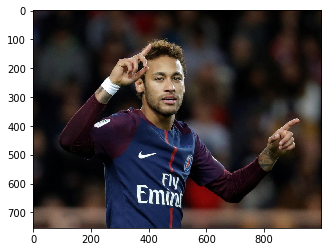

In [7]:
# Se genera una copia de la data cargada para poder procesarla
data_proc = data_encode.copy()
# Creacion de diccionario con los labels generados por DBSCAN y las imágenes que pertenecen a cada cluster
cluster_img = {str(x):[] for x in clt.labels_}
# Iteración sobre cada predicción
for i in range(len(pred)):
    # Hace un update sobre la data para identificar los cluster en una imagen
    data_proc[i].update({'Cluster':str(pred[i])})
    # Guarda información de la ruta de la imagen asociada al cluster
    cluster_img[str(pred[i])].append(data_proc[i]['imagePath']) 

# Muestra una imagen por cluster para poder identificar los jugadores
for l in np.unique(clt.labels_):
    if str(l) == '-1':
        print('Cluster Unkwnown')
    else:
        print('Cluster {}'.format(str(l)))
    img=mpimg.imread(cluster_img[str(l)][0])
    imgplot = plt.imshow(img)
    plt.show()


In [8]:
# Diccionar con el nombre de cada cluster
img_face_name = {'-1':'Unkwnown'
                 ,'0':'Cristiano Ronaldo'
                ,'1':'Lionel Messi'
                ,'2':'Luis Suarez'
                ,'3':'Mohamed Salah'
              ,'4':'Neymar'}
# Lista con las predicciones transformadas a los nuevos nombres de cluster
pred_new = []

# Carga de nuevos nombres de cluster
for i in pred:
    pred_new.append(img_face_name[str(i)])
    #data_proc[i].update({'Cluster_New':img_face_name[str(i)]})
# Update de la data procesada anexando los nuevos nombres de cluster
for i in range(len(pred)):
    data_proc[i].update({'Cluster_New':str(pred_new[i])})

#### 2.3
Indique cuántos futbolistas distintos (número de clústeres) hay en el data set.

In [9]:
# identificación de las imagenes no clusterizadas
unknown = [-1]
# obtención de los nombres de los cluster
tot_labels = np.unique(clt.labels_)
# resta de clusters totales - lo no clusterizado
tot_faces = list(set(tot_labels) - set(unknown))

print('Se detectaron {} distintas caras en las imagenes procesadas'.format(len(tot_faces)))

Se detectaron 5 distintas caras en las imagenes procesadas


#### 2.4
Genere una forma de visualizar los clústeres. Para esto extraiga cada cara de cada imagen y despliéguela en grupo. Despliegue hasta un máximo de 9 caras por grupo, ignore el resto. Cambie el tamaño de las imágenes para visualizar inteligentemente. Recuerde que en archivo generado en 2.1 existe esa información.

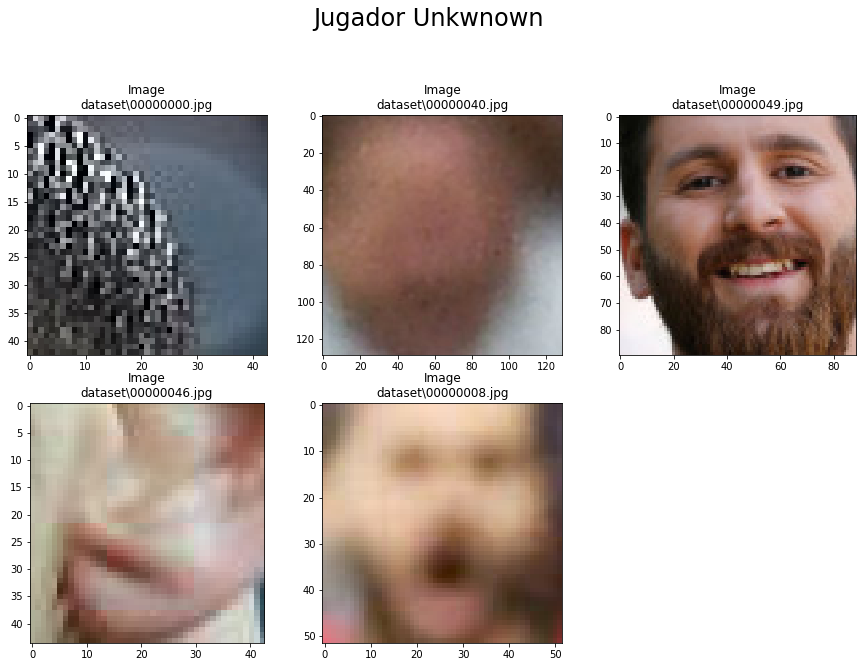

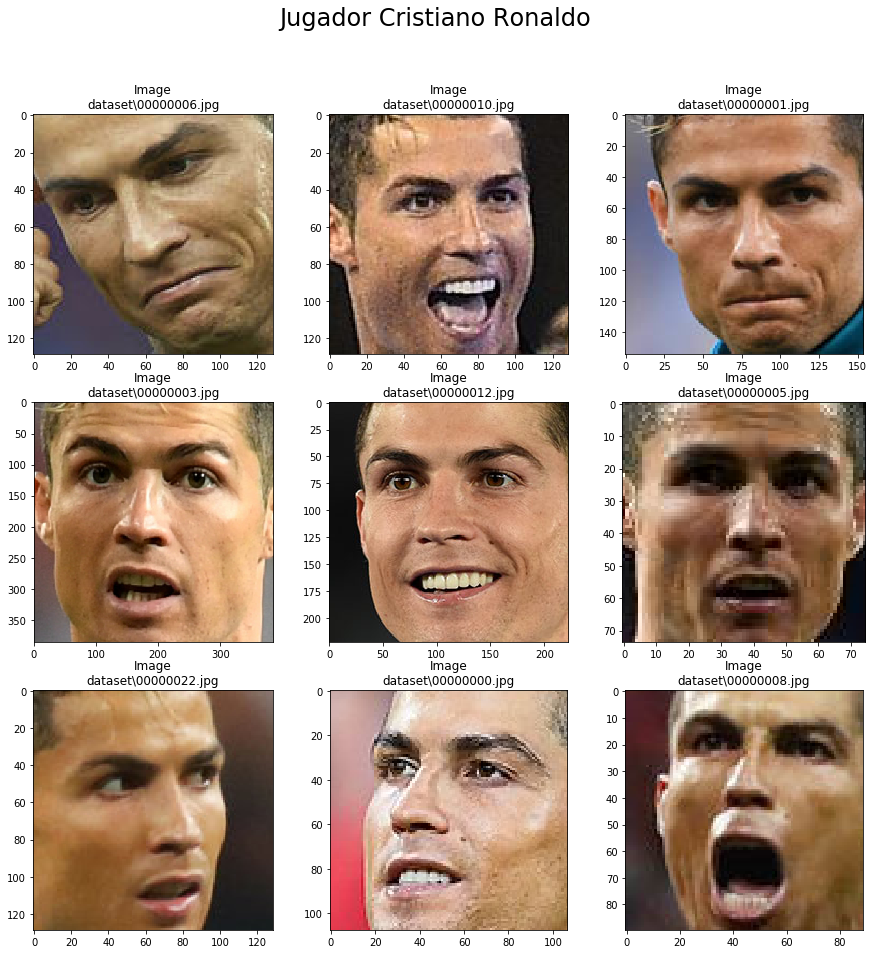

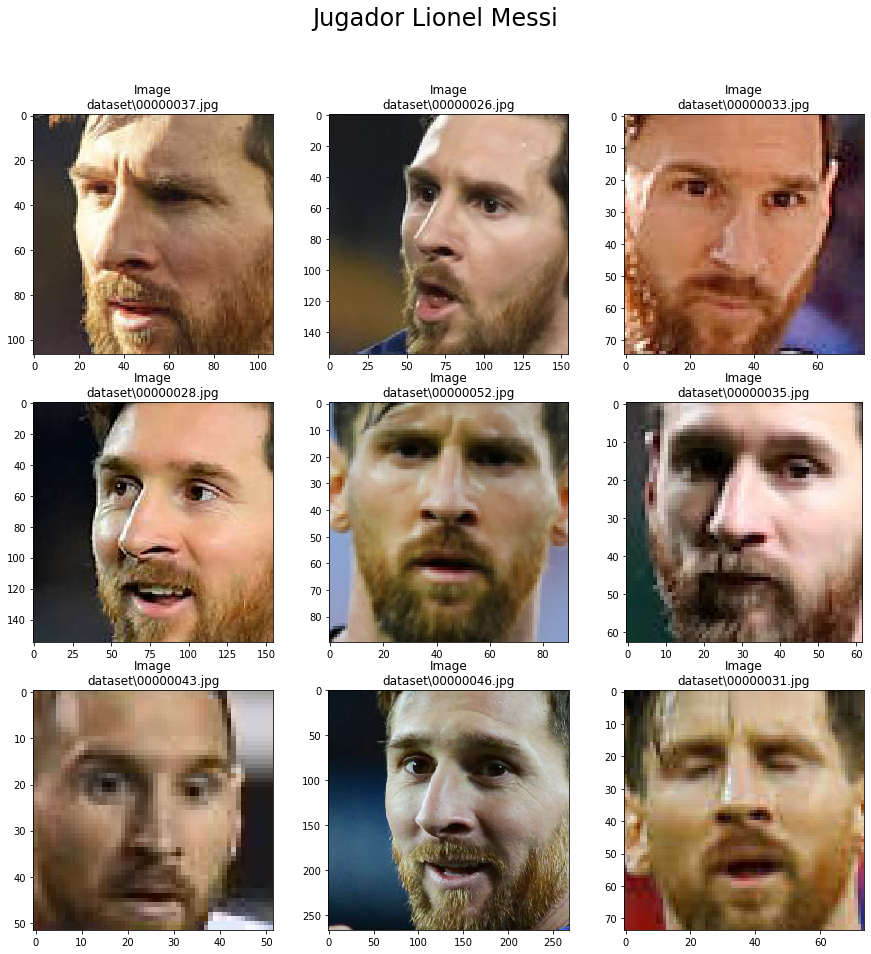

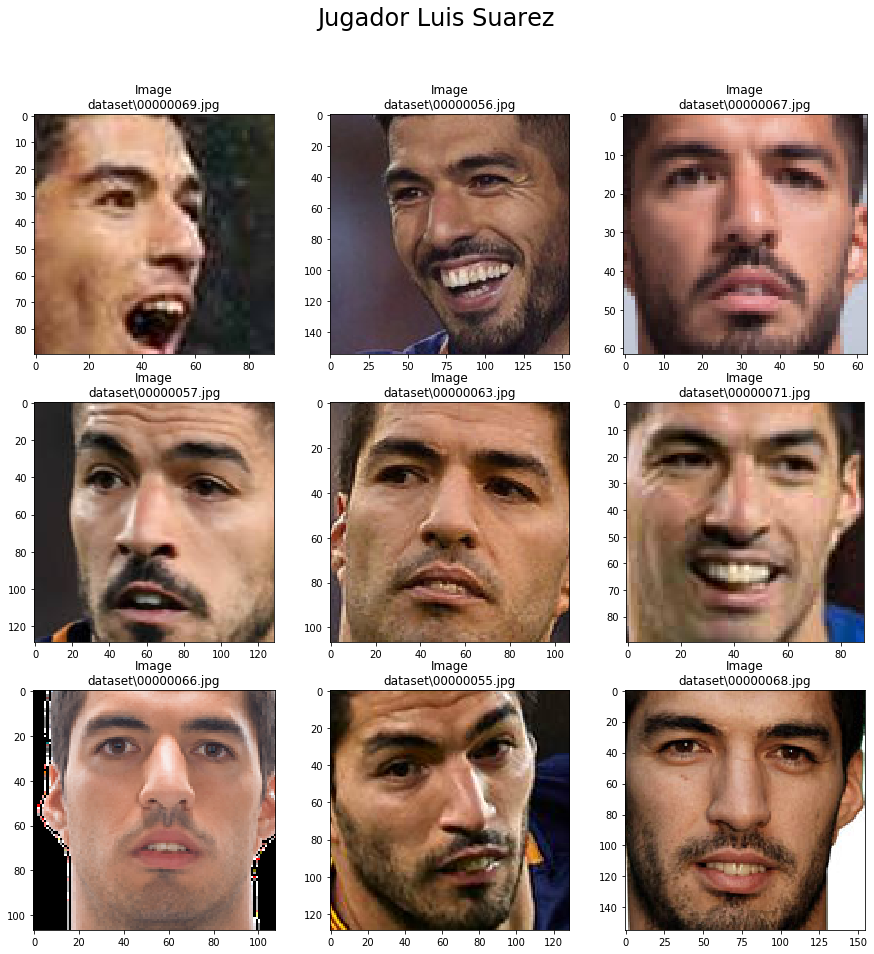

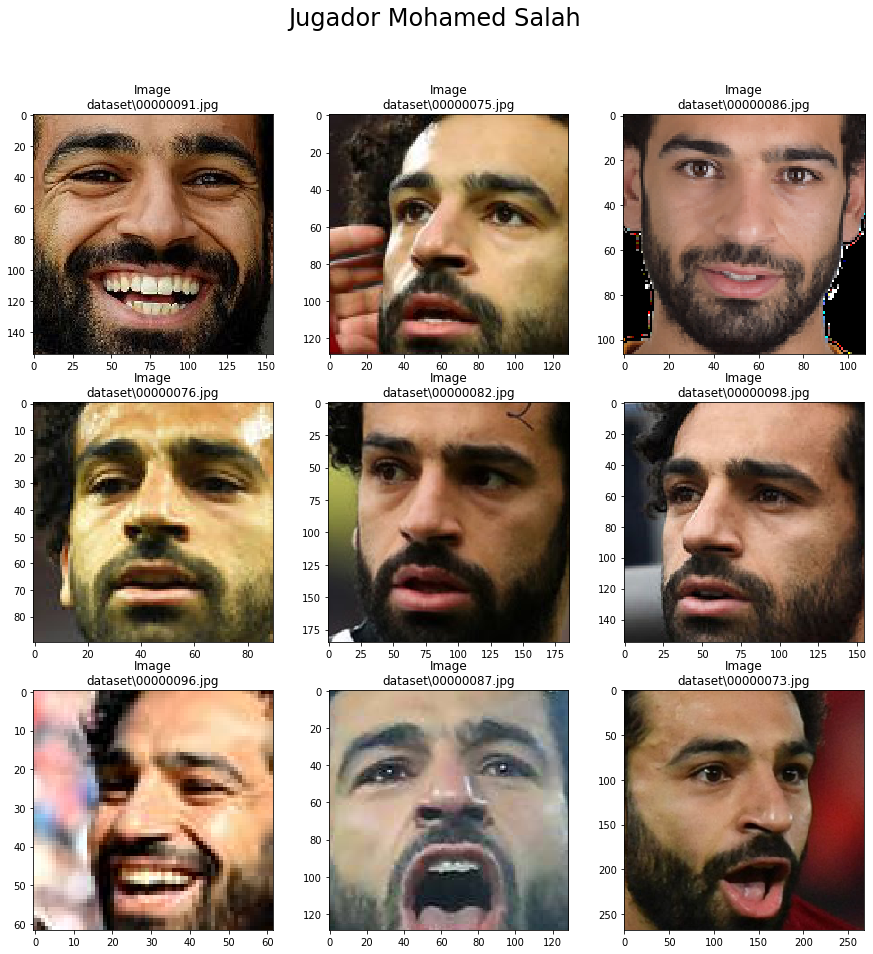

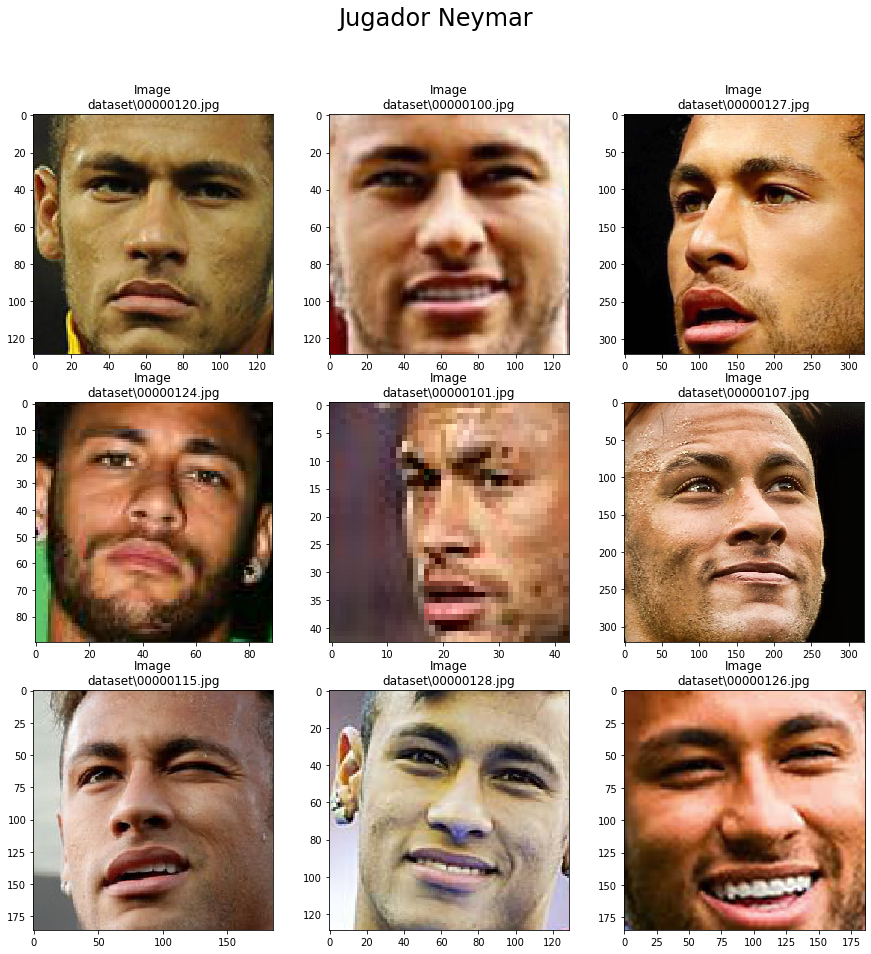

In [10]:
# Se muestran las imagenes de los clusters detectados
for c1,c2 in img_face_name.items():
    fig=plt.figure(figsize=(15, 15))
    fig.suptitle('Jugador {}'.format(c2), fontsize=24)
    # se genera array con listado de indices para cada cluster 
    idxs = np.where(np.array(pred_new) == c2)[0]
    # se escogen un maximo de 9 imagenes
    idxs = np.random.choice(idxs, size=min(9, len(idxs)),replace=False)
    faces = []
    ax = 1
    for i in idxs:
        # lectura de imagen asociada al valor en el array de indices
        image = cv2.imread(data_proc[i]["imagePath"])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Identificacion de la ubicacion de la cara detectada
        (top, right, bottom, left) = data_proc[i]["loc"]
        face = image[top:bottom, left:right]
        # Plots de cada cara 
        fig.add_subplot(3, 3, ax)
        plt.imshow(face)
        plt.title('Image\n{}'.format(data_proc[i]["imagePath"]))
        ax += 1
    plt.show()


#### 2.5
En el set de imágenes hay un futbolista que no podrá ser identificado porque no pertenecerá a ningún clúster (outlier). Despliegue su cara.

De las imagenes desplegadas anteriormente, existe un jugador que no se logra identificar en algun cluster y corresponde al de la imagen "**00000049.jpg**"

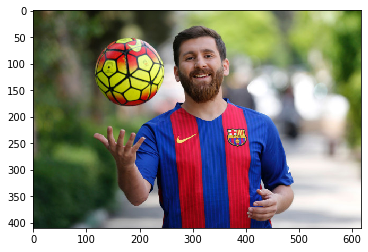

In [11]:
image = cv2.imread(data_proc[52]["imagePath"])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()